# NFL Concussion Prevention Analysis

*By Alex Wainger (Data Engineer, Facebook)*

### Proposed Rule Change
Eliminate the rule that kicking team players cannot go more than a yard past the line of scrimmage before a punt.$^{[1]}$

### Rationale
In this analysis, I'll show that removing this rule and allowing the kicking team to release downfield before the punt **will reduce punt-related concussions by ~33%** while minimally impacting the receiving team's starting field position and the occurence of exciting returns. Removing this rule will increase the fair-catch rate and discourage punt returns, which are the most dangerous part of the play.

### Background
The NFL introduced the rule before the 1974 season,$^{[2]}$ inspired by a similar rule change made by the NCAA in 1967.$^{[3]}$ The rule was part of "a package of changes to reinvigorate the game by...increasing the opportunity for big plays on kickoff and punt returns..."$^{[4]}$ in an effort to combat the launch of the World Football League — a rival league that "sought to attract fans with rules that were friendlier to the offense than the NFL’s" — in the year prior.$^{[4]}$ 

However, even in 1974, some were concerned about the health implications of this new rule. Bill Curry, President of the Players Association at the time, said "the possibility of wide‐open punt returns with bodies crashing downfield is anathema to the players."$^{[5]}$ Despite the concerns, the rule change was approved and has now been part of the NFL rulebook for 45 years.

Sources:
1. https://operations.nfl.com/the-rules/2018-nfl-rulebook/#article-2.-kicking-team-players-on-line-during-kick
2. https://en.wikipedia.org/wiki/1974_NFL_season#Major_rule_changes
3. https://en.wikipedia.org/wiki/1967_college_football_season#Rule_changes
4. https://operations.nfl.com/the-rules/evolution-of-the-nfl-rules
5. https://www.nytimes.com/1974/05/21/archives/changes-bynfl-opposed-nfl-rule-changes-bring-opposition.html

In [1]:
import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

## Loading Data + EDA

I'll spare you from going through all the exploration and visualization I did for this project. Instead, I'll show a couple relevant charts and numbers that inspired my proposed rule change.

In [2]:
# Loading all the datasets I built in the preprocessing notebook
play_information = feather.read_dataframe('../output/play_information.feather')
game_data = feather.read_dataframe('../output/game_data.feather')
play_player_role_data = feather.read_dataframe('../output/play_player_role_data.feather')
min_distances = feather.read_dataframe('../output/min_distances.feather')
second_min_distances = feather.read_dataframe('../output/second_min_distances.feather')
punt_hangtime = feather.read_dataframe('../output/punt_hangtime.feather')
video_review = feather.read_dataframe('../output/video_review.feather')

In [3]:
# Building a master play-level dataset
aug_play_information = play_information.merge(
    min_distances[['GameKey', 'PlayID', 'Coverage_Distance']],
    on=['GameKey', 'PlayID'], how='left', validate='one_to_one'
).merge(
    second_min_distances[['GameKey', 'PlayID', 'Coverage_Distance']],
    on=['GameKey', 'PlayID'], how='left', validate='one_to_one',
    suffixes=['_1', '_2']
).merge(
    game_data[['GameKey', 'Temperature', 'Is_Grass', 'Is_Outdoor']] ,
    on=['GameKey'], how='left', validate='many_to_one'
).merge(
    punt_hangtime[['GameKey', 'PlayID', 'Hangtime']],
    on=['GameKey', 'PlayID'], how='left', validate='one_to_one'
).merge(
    video_review,
    on=['GameKey', 'PlayID'], how='left', validate='one_to_one',
)

aug_play_information['Has_Concussion'] = ~aug_play_information.GSISID.isna()

In [4]:
plays_with_punts = aug_play_information[aug_play_information.Has_Punt]
plays_with_concussions = aug_play_information[aug_play_information.Has_Concussion]

print("Total plays:", aug_play_information.shape[0])
print("Plays with a punt:", plays_with_punts.shape[0])
print("Plays with a concussion:", plays_with_concussions.shape[0])
print("Plays with a punt and a concussion:", plays_with_concussions[plays_with_concussions.Has_Punt].shape[0])

Total plays: 6681
Plays with a punt: 6462
Plays with a concussion: 37
Plays with a punt and a concussion: 36


The 219 plays without a punt are mostly fakes and plays blown dead by penalties, and with only 1 concussion, I'm going to exclude them from the remainder of the analysis and focus on plays in which a punt actually occurs.

I looked at a bunch of slices of these 36 punt-related concussions, but one stood out in particular — concussion rates broken down by how the receiving team fielded the punt. I categorized the punt return type into 3 groups — fair catch, return, or unreturnable (i.e. punts out of bounds, downed punts, touchbacks, etc).

The difference in concussion rates on plays with and without returns is statistically significant.
p-value: 0.000001


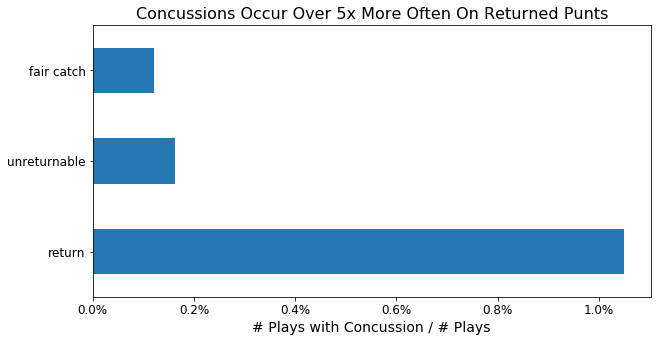

In [5]:
plays_with_concussions = plays_with_concussions[plays_with_concussions.Has_Punt]

concussion_rates = plays_with_concussions.Punt_Type.value_counts() / plays_with_punts.Punt_Type.value_counts()
ax = concussion_rates.plot(
    kind='barh', figsize=(10,5), color='#2678B2', fontsize=12,
    title='Concussions Occur Over 5x More Often On Returned Punts')
vals = ax.get_xticks()
ax.set(xlabel="# Plays with Concussion / # Plays", xticklabels=['{:,.1%}'.format(x) for x in vals]);
ax.xaxis.label.set_size(14)
ax.title.set_size(16)

ttest_res = ttest_ind(
    plays_with_punts[plays_with_punts.Has_Return].Has_Concussion, 
    plays_with_punts[~plays_with_punts.Has_Return].Has_Concussion
)

if ttest_res.pvalue < .05:
    print('The difference in concussion rates on plays with and without returns is statistically significant.')
else:
    print('The difference in concussion rates on plays with and without returns is not statistically significant.')
print('p-value:', '%f' % ttest_res.pvalue)

With a concussion rate of over 1%, a player is over 5x more likely to get concussed on a punt play with a return than a play without one (and this difference is statistically significant). This makes intuitive sense, as I would have guessed that the most dangerous part of a punt play was during the return, when there are clusters of players running into each other from all directions.

To validate this finding, I reviewed all of the videos of the plays with concussions. **Of the 31 concussions that occurred on plays with returns, 30 of the concussions occurred after the punt was caught by the returner**. This point is essential to the rest analysis — fair catch plays and return plays are essentially identical up until the moment the punt returner catches the ball. In one, the play ends the moment the ball is caught, in the other, players run full-speed into one another from all sides.

Therefore, incentivizing punt returners to call more fair catches, rather than returning punts, should reduce the overall concussion rate, as the return play concussions would not happen if the play ended when the punt was caught.

## FAIR CATCH MODEL

In order to incentivize teams to call more fair catches, I first had to understand what the drivers of fair catches were.

I had a hypothesis that the distance between the punt returner and the nearest member of the kicking team would give us a lot of information about whether or not a fair catch was called. To prove it, I built a model to predict whether or not a punt play ended with a fair catch.

### Features

 - **Coverage_Distance_1 and Coverage_Distance_2:** Coverage distance is the distance between the punt returner and a member of the coverage team at the moment the punt is caught. Each play has 11 coverage distance values (one for each member of the coverage team), so we pick the smallest and second smallest and assign them the \_1 and \_2 subscripts, respectively. 
 - **Punt_Distance:** How many yards the punt traveled.
 - **Time_Passed_Sec:** How many seconds of game-time have passed when the punt is happening. 0 and 3600 represent the start and end of the game, 900, 1800, and 2700 represent the start of the second, third, and fourth quarters, etc.
 - **Score_Differential:** kicking team score - receiving team score
 - **Yard_Line_Absolute:** The line of scrimmage, represented as a number between 0 and 100. 0 represents the kicking team's goal line, 100 represents the receiving team's goal line.
 - **Hangtime:** Amount of time between ball leaving punter's foot and the punter returning catching it.
 - **Temperature:** For outdoor games, it's the temperature outside, for indoor games, 70 was used to represent an average indoor stadium temperature (as we don't have the inside temperature available)
 - **Is_Grass:** Boolean, whether or not the game is being played on grass.
 - **Is_Outdoor:**: Boolean, whether or not the game is being played outdoors.

In [6]:
plays_with_return = plays_with_punts[plays_with_punts.Has_Return]
plays_with_fair_catch = plays_with_punts[plays_with_punts.Has_Fair_Catch]

In [7]:
label = ['Has_Fair_Catch']
features = [
    'Punt_Distance', 'Time_Passed_Sec', 'Score_Differential',
    'Yard_Line_Absolute', 'Coverage_Distance_1', 'Coverage_Distance_2',
    'Hangtime', 'Temperature', 'Is_Grass', 'Is_Outdoor'
]

plays_with_return_or_fc = pd.concat(
    [plays_with_return, plays_with_fair_catch]
)[['GameKey', 'PlayID'] + features + label].dropna()

x_train, x_test, y_train, y_test = train_test_split(
    np.array(plays_with_return_or_fc[features]),
    np.array(plays_with_return_or_fc[label]).ravel(),
    test_size=0.2,
    random_state=0
)

In [8]:
parameters = {
    'n_estimators':[10, 50, 100],
    'learning_rate': [.01, .05, .1],
    'max_depth': [1, 2, 3]
}
# enc = OneHotEncoder()
search = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, cv=3)
search.fit(x_train, y_train)

print(search.best_params_)

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}


The model is trained on punts with returns as negative examples (unreturnable punts aren't really relevant here, since we're trying to learn how to convert returns to fair catches) and performs pretty well! Given the sample sizes we're working with, the data we have available and it's reliability, and the amount of actual randomness in the decision to call a fair catch, I'm happy with the accuracy.

In [9]:
# Using best params from grid-search above
gbdt = GradientBoostingClassifier(
    n_estimators=search.best_params_['n_estimators'],
    learning_rate=search.best_params_['learning_rate'],
    max_depth=search.best_params_['max_depth'],
    random_state=0
).fit(x_train, y_train)

y_scores_gbdt = gbdt.predict_proba(x_test)[:,1]

print("Train accuracy:",gbdt.score(x_train, y_train))
print("Test accuracy:", gbdt.score(x_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_gbdt))

Train accuracy: 0.8513363028953229
Test accuracy: 0.844097995545657
ROC AUC: 0.9150970622668735


Looking at the feature importances for our fair-catch model, my original hypothesis was correct — the minimal coverage distance is by far the most important feature in predicting whether or not a fair catch was called.

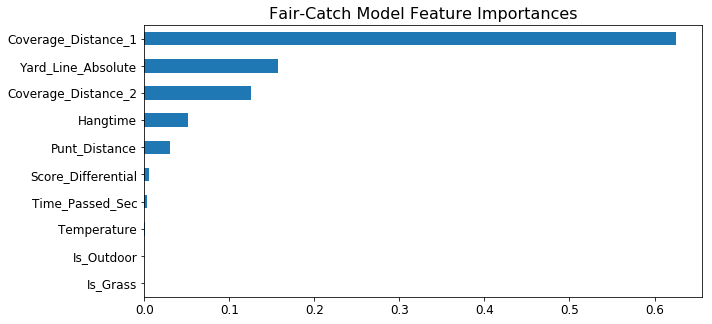

In [10]:
ax = pd.DataFrame(
    gbdt.feature_importances_,
    index = features,
    columns=['importance']
).sort_values('importance', ascending=True).plot(
    title='Fair-Catch Model Feature Importances', kind='barh', legend=False, figsize=(10,5), fontsize=12
)

ax.title.set_size(16)

So we know coverage distance is by far the most important feature in predicting fair catches. Logically, there is probably an inverse relationship between coverage distance and fair catches, i.e. smaller coverage distance --> larger odds of a fair catch. To confirm this, I trained a logistic regression model to look at the direction of the coefficients -- and it's right!

Train accuracy: 0.8243318485523385
Test accuracy: 0.8307349665924276
ROC AUC: 0.8942361621606905


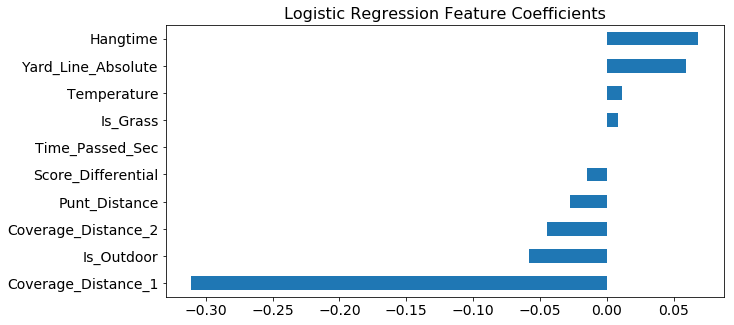

In [11]:
logreg = LogisticRegression(solver='liblinear', random_state=2).fit(x_train, y_train)
y_scores_logreg = logreg.predict_proba(x_test)[:,1]
y_pred_logreg = logreg.predict(x_test)

print("Train accuracy:",logreg.score(x_train, y_train))
print("Test accuracy:", logreg.score(x_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_logreg))

ax = pd.DataFrame(
    logreg.coef_.transpose(),
    index=features,
    columns=['coefficients']
).sort_values('coefficients').plot(
    kind='barh', legend=False, title='Logistic Regression Feature Coefficients', figsize=(10,5), fontsize=14
)

ax.title.set_size(16)


## Estimating Impact of the Rule Change

Knowing what we now know about fair catches, the rule holding non-gunners at the line of scrimmage until the punt stood out as an area of opportunity — it gives returners space to advance the ball, which we know is associated with higher concussion rates.

Removing the rule would allow players to release downfield into coverage whenever they want. It will strictly decrease the minimal coverage distance — conservative teams afraid of punt blocks will hold their blocking as long as they do now, while more aggressive teams will leave the line of scrimmage well before the punt leaves the punter's foot.

To estimate how many returns get converted into fair catches, I did the following:
1. Measure the amount of time between the snap and punt events.
2. Calculate the average speed of each kicking-team non-gunner between the punt and the reception.
3. Picking some fraction to represent how much sooner the kicking team would start downfield, calculate "adjusted coverage distances" —
   1. For gunners, this is the same as the coverage distance we originally calculated for the model
   2. For non-gunners, *adjusted_coverage_distance = coverage_distance - (snap_to_punt_time X average_speed X blocking_to_coverage_time_fraction)*
4. Feed the smallest and second smallest adjusted coverage distances back into our trained fair catch model that we developed earlier and see how many returns are now predicted to be fair catches.

I picked 0.5 for the blocking_to_coverage_time_fraction, which means in my simulation, the non-gunners will start heading downfield half way between the snap and the punt. As I wrote above, conservative teams may not send their players much earlier, while aggressive teams may just chip the receiving blockers and then head downfield, so 0.5 seemed like a reasonable middle ground.

In [12]:
def update_coverage_distance(row):
    snap_to_punt_time_adjustment = .5 # Percentage of blocking time converted to coverage time
    minimal_coverage_distance = .5 # don't let adjusted coverage distance get smaller than half a yard
    if 'GL' in row.Role_k or 'GR' in row.Role_k:
        return row.Coverage_Distance
    else:
        return max(
            row.Coverage_Distance - (
                row.Yards_Per_Second * (
                    row.Snap_To_Punt_time * snap_to_punt_time_adjustment
                )
            ), minimal_coverage_distance
        )

In [13]:
# Calculate Adjusted Coverage Distances
adjusted_coverage_distances = feather.read_dataframe('../output/adjusted_coverage_distances.feather')

adjusted_coverage_distances['Adj_Coverage_Distance'] = adjusted_coverage_distances.apply(
    update_coverage_distance, axis=1
)

min_acd = adjusted_coverage_distances.loc[
    adjusted_coverage_distances.groupby(['GameKey', 'PlayID'])['Adj_Coverage_Distance'].idxmin()
][['GameKey', 'PlayID', 'Adj_Coverage_Distance', 'Role_k', 'Super_Role_k']]

adjusted_coverage_distances_2 = adjusted_coverage_distances.drop(
    adjusted_coverage_distances.groupby(['GameKey', 'PlayID'])['Adj_Coverage_Distance'].idxmin()
)

second_min_acd = adjusted_coverage_distances_2.loc[
    adjusted_coverage_distances_2.groupby(['GameKey', 'PlayID'])['Adj_Coverage_Distance'].idxmin()
][['GameKey', 'PlayID', 'Adj_Coverage_Distance', 'Role_k', 'Super_Role_k']]

Looking first at the breakdown of which member of the coverage team is closest to the punt returner at punt reception time, we can see that the rule change drastically changes the distribution. In the game today, gunners are the closest player nearly 80% of the time, but that number gets nearly cut in half after my rule change. This is a good sign for the rule change, as it means the minimum coverage distance is getting smaller, as linemen and protectors are getting to the punt returner before the gunners much more often.

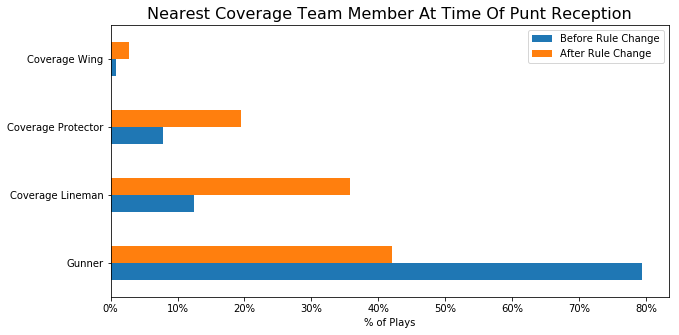

In [14]:
ax = pd.DataFrame(
    {
        "Before Rule Change": min_distances.Super_Role_k.value_counts() / min_acd.shape[0],
        "After Rule Change": min_acd.Super_Role_k.value_counts() / min_acd.shape[0]
    }
).plot(
    kind='barh', figsize=(10,5), title='Nearest Coverage Team Member At Time Of Punt Reception'
)

vals = ax.get_xticks()
ax.set(xlabel="% of Plays", xticklabels=['{:,.0%}'.format(x) for x in vals])

ax.title.set_size(16)

In [15]:
# Evaluate trained model on new adjusted coverage distance features
adj_features = [
    'Punt_Distance', 'Time_Passed_Sec', 'Score_Differential',
    'Yard_Line_Absolute', 'Adj_Coverage_Distance_1', 'Adj_Coverage_Distance_2',
    'Hangtime', 'Temperature', 'Is_Grass', 'Is_Outdoor'
]

adj_X = plays_with_return_or_fc.merge(
    min_acd, on=['GameKey', 'PlayID'], how='inner', validate='one_to_one'
).merge(
    second_min_acd, on=['GameKey', 'PlayID'], how='inner', validate='one_to_one', suffixes=["_1", "_2"]
)

adj_X['Adj_Has_Fair_Catch_pred'] = gbdt.predict(adj_X[adj_features]) | adj_X.Has_Fair_Catch

In [16]:
adj_plays_with_punts = plays_with_punts.merge(
    adj_X[['GameKey', 'PlayID', 'Adj_Has_Fair_Catch_pred']],
    on=['GameKey', 'PlayID'], how='left', validate='one_to_one'
)

adj_plays_with_punts['Adj_Punt_Type'] = adj_plays_with_punts.apply(
    lambda row:
        row.Punt_Type
        if pd.isna(row.Adj_Has_Fair_Catch_pred)
        else (
            'fair catch'
            if row.Adj_Has_Fair_Catch_pred
            else 'return'
        )
    , axis=1
)
adj_plays_with_punts['Adj_Has_Fair_Catch_pred'] = adj_plays_with_punts.Adj_Punt_Type == 'fair catch'
adj_plays_with_punts['Adj_Punt_Return_Length'] = adj_plays_with_punts.apply(
    lambda row:
        row.Punt_Return_Length
        if not row.Adj_Has_Fair_Catch_pred
        else 0.0
    , axis=1
)

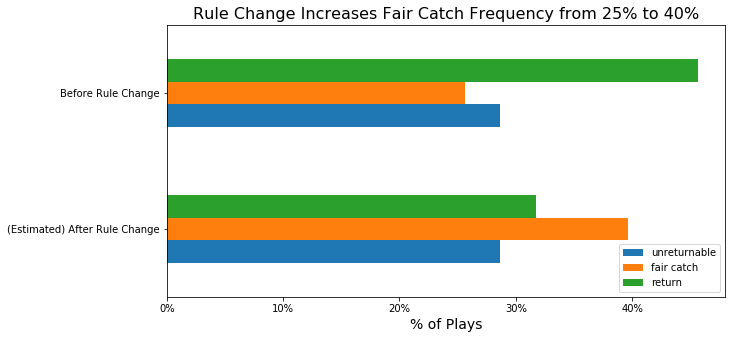

In [17]:
ax = pd.DataFrame(
    {
        "(Estimated) After Rule Change": adj_plays_with_punts.Adj_Punt_Type.value_counts() / adj_plays_with_punts.shape[0],
        "Before Rule Change": adj_plays_with_punts.Punt_Type.value_counts() / adj_plays_with_punts.shape[0]
    }, index=adj_plays_with_punts.Punt_Type.unique()
).transpose().plot(kind='barh', title='Rule Change Increases Fair Catch Frequency from 25% to 40%', figsize=(10,5))
vals = ax.get_xticks()
ax.set(xlabel="% of Plays", xticklabels=['{:,.0%}'.format(x) for x in vals]);

ax.xaxis.label.set_size(14)
ax.title.set_size(16)


By reevaluating the model with the adjusted coverage distance features, we can essentially simulate the two seasons of punting with my rule change and see what kind of effects it has. As expected, the percent of plays that end with a fair catch jumps from 25% to 40% and becomes the most common way to end a punt play.

### Concussion Rate

In [18]:
pre_concussions = adj_plays_with_punts.Has_Concussion.sum()
post_concussions = (
    adj_plays_with_punts.Has_Concussion & ~(
        (adj_plays_with_punts.Punt_Type == 'return') & (adj_plays_with_punts.Adj_Punt_Type == 'fair catch')
    )
).sum()
print("# Concussions Before Rule Change:", pre_concussions)
print("# Concussions After Rule Change:", post_concussions)
print("Percent Decrease in Concussions: {:,.1%}".format((pre_concussions - post_concussions) / pre_concussions))

# Concussions Before Rule Change: 36
# Concussions After Rule Change: 24
Percent Decrease in Concussions: 33.3%


To understand the impact that this rule change could have on the occurrences of concussions, I removed any concussions that happened on returns that got converted to fair catches after the rule change. This is obviously a rough estimate, as there are a number of assumptions and randomness baked into this analysis, but the result shows that converting returns to fair catches could have a significant impact on overall concussion rates.

### Field Position and "Exciting" Returns

So concussion rates are going down, great! But what if this rule change takes away all the excitement of punt returns, or drastically changes the average starting field position for the receiving team? Luckily, the increases in fair catches doesn't have too big an impact on either.

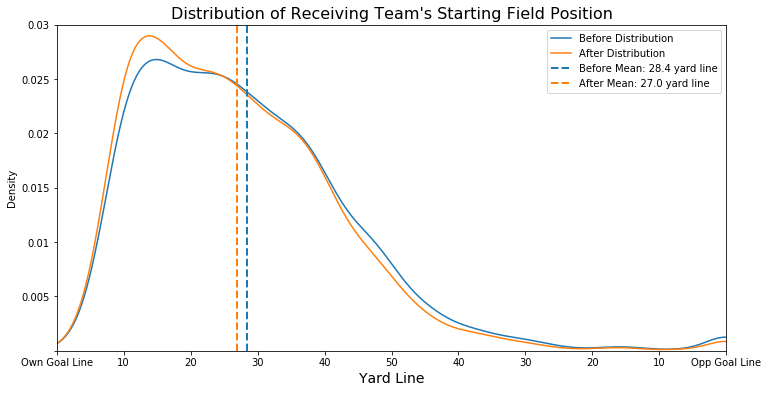

In [21]:
exciting_return_length = 20

adj_plays_with_punts['Next_Poss_Yard_Line'] = adj_plays_with_punts.apply(
    lambda row:
        np.nan
        if row.Punt_Type == 'unreturnable'
        else 100 - (row.Yard_Line_Absolute + row.Punt_Distance - row.Punt_Return_Length)
    , axis=1
)

adj_plays_with_punts['Adj_Next_Poss_Yard_Line'] = adj_plays_with_punts.apply(
   lambda row:
        np.nan
        if row.Adj_Punt_Type == 'unreturnable'
        else 100 - (row.Yard_Line_Absolute + row.Punt_Distance - row.Adj_Punt_Return_Length)
    , axis=1
)

adj_plays_with_returnable_punts = adj_plays_with_punts[
    adj_plays_with_punts.Has_Return | adj_plays_with_punts.Has_Fair_Catch
]

ax = pd.DataFrame(
    {
        'Before Distribution':adj_plays_with_returnable_punts.Next_Poss_Yard_Line,
        'After Distribution': adj_plays_with_returnable_punts.Adj_Next_Poss_Yard_Line
    }
).plot(
    kind='density', xlim=(0,100), ylim=(0,.03), figsize=(12,6),
    title='Distribution of Receiving Team\'s Starting Field Position',
)

before_mean_yard_line = adj_plays_with_returnable_punts.Next_Poss_Yard_Line.mean()
after_mean_yard_line = adj_plays_with_returnable_punts.Adj_Next_Poss_Yard_Line.mean()

yard_line_vals = [0,10,20,30,40,50,60,70,80,90,100]
yard_line_labels = [
    'Own Goal Line' if x == 0
    else (
        'Opp Goal Line' if x == 100
        else (
            x if x <= 50 
            else 100-x
        )
    ) for x in yard_line_vals]
ax.set(
    xlabel="Yard Line", xticks=yard_line_vals, xticklabels=yard_line_labels,
    yticklabels= [''] + [str(x) for x in ax.get_yticks()[1:]]
)
plt.axvline(
    before_mean_yard_line, linestyle='dashed', color='tab:blue', linewidth=2,
    label='Before Mean: {:,.1f} yard line'.format(before_mean_yard_line)
)
plt.axvline(
    after_mean_yard_line, linestyle='dashed', color='tab:orange', linewidth=2,
    label='After Mean: {:,.1f} yard line'.format(after_mean_yard_line)
)
ax.xaxis.label.set_size(14)
ax.title.set_size(16)
plt.legend();

Average starting field position drops by just a yard and a half, from the 28.4 to the 27. After the rule change, we see a small spike around the 15 and a small decrease in frequency of drives starting between the 40's. These are pretty minimal effects given the amount we're reducing concussions by.

In [20]:
print("Of All Punts (returnable and unreturnable)")
print("    Percent of total punt plays with >20 yard return before change: {:,.1%}".format(
    (adj_plays_with_punts.Punt_Return_Length > exciting_return_length).sum() / adj_plays_with_punts.shape[0]
))
print("    Percent of total punt plays with >20 yard return after change: {:,.1%}".format(
    (adj_plays_with_punts.Adj_Punt_Return_Length > exciting_return_length).sum() / adj_plays_with_punts.shape[0]
))

Of All Punts (returnable and unreturnable)
    Percent of total punt plays with >20 yard return before change: 4.1%
    Percent of total punt plays with >20 yard return after change: 3.1%


While 4.1% to 3.1% represents a ~25% decrease in plays with an "exciting" punt return (defined here as a return of 20 yards or more), the fact that only 1 in 25 punts end up having an exciting return even without the rule change likely means fans won't notice the downtick, as long as there is still a big run back every now and then.

## Unintended Consequences

In terms of effects I can reasonably estimate with data, the rule change seems to do exactly what I want it to do. However, there could still be side-effects or unintended consequences of the rule change. It's hard to quantify how each of these mind affect the game, but I don't think any of them outweigh the reduction in concussions.

#### NCAA-style Rugby Rollout Punts
Since the NCAA allows the kicking team to release downfield on the snap, we can learn a lot from college teams cover punts. The most obvious difference between the college and professional punting game is the use of a rugby-style punt — some college teams will roll their punter out toward the sideline, buying time for the rest of the coverage team to sprint further downfield than they would with a standard 3-step punt. My rule change could cause a rise an inadvertent rise in this type of strategy.

However, I don't actually think rugby rollout punts would catch on in the NFL. College punters often don't have the leg strength to hit a 50 yard punt with 4-5 seconds of hangtime. As a result, teams turn to a gimmicky play to compensate. At the NFL level, punters can boom kicks far and high enough that coverage teams have time to get down field with just 1-2 seconds before the kick (and they'll have even more time under my rule change). Top NCAA teams like Alabama or Clemson, which sport NFL-ready punters, mostly stay traditional with their punt style.

The rugby rollout also requires a very particular skill-set — ability to punt (or at least threaten to punt) with either leg while on the run — that most NFL punters likely don't practice. Initially, teams may try the tactic, but it would take a few seasons of experimenting and practice under the rule change to master the rugby rollout, at which point the NFL would have some data to evaluate whether or not it's good for the game.

#### Increase in Fake Punt Runs

...